In [1]:
# Step 1: Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import load_img, img_to_array

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
# Step 2: Load & preprocess a single image
img_path = "golden_retriever.jpg"   
target_size = (128, 128)

img = load_img(img_path, target_size=target_size)   # loads as RGB
img = img_to_array(img) / 255.0                     # to float32, normalize [0,1]

if img.ndim == 2:
    img = np.stack([img, img, img], axis=-1)

# Add batch dimension: (1, H, W, 3)
x = np.expand_dims(img, axis=0)
print("Input batch shape:", x.shape)

Input batch shape: (1, 128, 128, 3)


In [3]:
# Step 3: Define the CNN with 5 conv blocks
inputs = Input(shape=(target_size[0], target_size[1], 3))

# Block 1
x1 = layers.Conv2D(16, (3,3), padding='same', activation='relu', name='block1_conv')(inputs)
p1 = layers.MaxPooling2D((2,2), name='block1_pool')(x1)

# Block 2
x2 = layers.Conv2D(32, (3,3), padding='same', activation='relu', name='block2_conv')(p1)
p2 = layers.MaxPooling2D((2,2), name='block2_pool')(x2)

# Block 3
x3 = layers.Conv2D(64, (3,3), padding='same', activation='relu', name='block3_conv')(p2)
p3 = layers.MaxPooling2D((2,2), name='block3_pool')(x3)

# Block 4
x4 = layers.Conv2D(128, (3,3), padding='same', activation='relu', name='block4_conv')(p3)
p4 = layers.MaxPooling2D((2,2), name='block4_pool')(x4)

# Block 5
x5 = layers.Conv2D(256, (3,3), padding='same', activation='relu', name='block5_conv')(p4)
p5 = layers.MaxPooling2D((2,2), name='block5_pool')(x5)

# Model that outputs the feature maps after each block's pooling
model = models.Model(inputs=inputs, outputs=[p1, p2, p3, p4, p5])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv (Conv2D)                 │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv (Conv2D)                 │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv (Conv2D)                 │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv (Conv2D)                 │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv (Conv2D)                 │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 392,608 (1.50 MB)

 Trainable params: 392,608 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Step 4: Run a forward pass to get outputs of each block
feature_maps = model.predict(x)

for i, fmap in enumerate(feature_maps, start=1):
    print(f"Block {i} output shape: {fmap.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
Block 1 output shape: (1, 64, 64, 16)
Block 2 output shape: (1, 32, 32, 32)
Block 3 output shape: (1, 16, 16, 64)
Block 4 output shape: (1, 8, 8, 128)
Block 5 output shape: (1, 4, 4, 256)


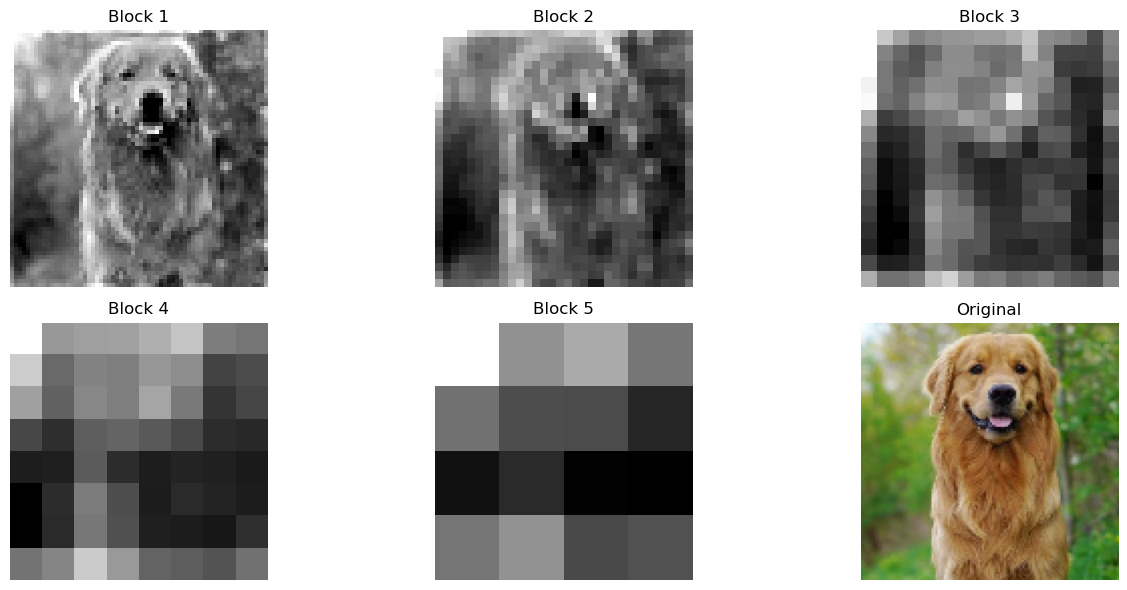

In [5]:
# Step 5: Visualize the mean feature map from each block
plt.figure(figsize=(14, 6))

for i, fmap in enumerate(feature_maps, start=1):
    # fmap shape: (1, H, W, C) -> remove batch -> (H, W, C)
    fmap_hw_c = fmap[0]
    # Mean across channels -> (H, W)
    fmap_mean = fmap_hw_c.mean(axis=-1)

    # Normalize to [0,1] for a nicer contrast in plotting
    vmin, vmax = np.percentile(fmap_mean, [1, 99])
    fmap_norm = np.clip((fmap_mean - vmin) / (vmax - vmin + 1e-8), 0, 1)

    plt.subplot(2, 3, i)
    plt.imshow(fmap_norm, cmap='gray')
    plt.title(f'Block {i}')
    plt.axis('off')

# Original for reference
plt.subplot(2, 3, 6)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.tight_layout()
plt.show()